# Exploring The Data and Feature Engineering

Notebook to clean the scraped data and to try and engineer features that will help determine the level. The features I will be engineering are: presence of different verb tenses, frequency of most common Spanish words, average sentence length, and proportion of unique words in the text.

## First Steps

In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize

In [59]:
#import files and concatanate them.
#files containing rl were scraped from readlang, a language text sharing site
#df_other is from Lawless Spanish, a Spanish education site
df_rl_A1 = pd.read_csv (r'./readlang_A1.csv')
df_rl_A2 = pd.read_csv (r'./readlang_A2.csv')
df_rl_B1 = pd.read_csv (r'./readlang_B1.csv')
df_rl_B2 = pd.read_csv (r'./readlang_B2.csv')
df_rl_C1 = pd.read_csv (r'./readlang_C1.csv')
df_rl_C2 = pd.read_csv (r'./readlang_C2.csv')
df_other = pd.read_csv(r'./spanish_reading_texts.csv')

frames = [df_rl_A1, df_rl_A2, df_rl_B1, df_rl_B2, df_rl_C1, df_rl_C2, df_other]
df = pd.concat(frames, ignore_index=True)

In [60]:
df.head()

,Level,Text
0,A1,Hazlo por tu padre o por tu madre.Aguanta por ...
1,A1,Hola
2,A1,1. ¿En qué se parece un esqueleto a una comida...
3,A1,Hola soy Beatriz y estamos al frente de la Igl...
4,A1,Hola. Nos encontramos en Lima Perú en el distr...


In [61]:
df.describe()

,Level,Text
count,620,614
unique,7,609
top,B2,Mientras estoy en la escuela tenemos un descan...
freq,139,3


In [62]:
#Drop all duplicate values as they are likely non-useful
df = df.drop_duplicates(subset='Text')

#Replace new line formatting with full stops
df = df.replace('\n', '. ', regex=True)

#Drop all levels entries where Text is null
df = df.dropna()

#Need to check why there are 7 different levels
df.describe()

,Level,Text
count,609,609
unique,7,609
top,B2,Platero y yo. Juan Ramon Gimenez. Platero es p...
freq,137,1


In [12]:
df.Level.value_counts()

B1    57
C2    38
B2    37
C1    37
A1     8
A2     8
Name: Level, dtype: int64

In [64]:
#Can't tell what the levels are actually are so need to drop them
print(df[df.Level == '?!'])

    Level                                               Text
499    ?!  Julieta ¿Julieta? ¡Bea! No me lo puedo creer ¿...
536    ?!  Bernarda declara ocho años de luto [Bernarda] ...
561    ?!  Arabismos Cuando pensamos en la cultura árabe ...
571    ?!  Despacito [Fonsi:] Sí sabes que ya llevo un ra...
578    ?!  La Familia Addams - premier en Madrid Reporter...


In [65]:
df = df[df.Level != '?!']
df.describe()

,Level,Text
count,604,604
unique,6,604
top,B2,Platero y yo. Juan Ramon Gimenez. Platero es p...
freq,137,1


### Verb Tenses with The Part Of Speech Tagger
Spanish learners are introduced to different tenses gradually as they get better. As such, the presence of different tenses in a text should give us insight into it's level.

The Stanford POS tagger will analyse the texts word by word and return a key representing what part of speech the word falls under. The function below will return counts for each verb tense as well as multiple different variables that will be useful for later engineering. The POS tagger will also highlight most non-Spanish texts as it will get stuck when trying to tag them, using a timeout system these texts can be identified and later deleted. 

Computationally expensive! Takes about 5s per text.

In [24]:
#Import and setup the POStagger.

#StanfordPOSTagger is best for Spanish. However, it needs to be accessed through Java
from nltk.tag import StanfordPOSTagger
jar = '/Users/davidhunter/Downloads/stanford-postagger-full-2018-10-16/stanford-postagger-3.9.2.jar'
model = '/Users/davidhunter/Downloads/stanford-postagger-full-2018-10-16/models/spanish.tagger'

import os
java_path = "/System/Library/Frameworks/JavaVM.framework/Versions/Current/Commands/java"
os.environ["JAVAHOME"] = java_path

#tags each word by word type 
#codes can be found here: https://web.archive.org/web/20160325024315/http://nlp.lsi.upc.edu/freeling/doc/tagsets/tagset-es.html
#In the above list the last 3 digits are always set to 000 in this tagger. It does not provie that last level of specificity
pos_tagger = StanfordPOSTagger(model, jar, encoding='utf8' )
pos_tagger.tag('voy a decir'.split())    

[('voy', 'vmip000'), ('a', 'sp000'), ('decir', 'vmn0000')]

In [25]:
#Function to check the tenses present in the text
#Uses the StanfordPOStagger
#Would get stuck if the text was non-Spanish, included timout feature to account for this 
from collections import Counter
import signal

#Set empty dictionary to store the non Spanish id's for deletion later
non_spanish = []

#Generous time limit
timelimit_seconds = 20

#Classes and functions for the time out process
class TimeoutException(Exception):
    pass

def signal_handler(signum, frame):
    raise TimeoutException()

#Tense checking function, takes a text (words) and a number for identification purposes (z)
def TenseChecker(text, z=0):
    
    #Checks for null values and adds them to delete list.
    if text == 0:
        text = 'hola'
        non_spanish.append(z)
    
    #Sets and starts the timer
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(timelimit_seconds)
    
    try:
        #words is a tuple list of the words and their codes
        words = pos_tagger.tag(text.split())
        
        length = len(words)

        #extract just the codes
        codes = [x[1] for x in words]
        
        #Creating a list of each word for later use
        words_list = [x[0] for x in words]
        
        #Counts the frequencies of each verb code
        counter = Counter(codes)
        
        #Creates a total for each verb tense from the counter
        imperfect_past = counter['vmii000'] + counter['vsii000'] + counter['vaii000']
        simple_past = counter['vmis000'] + counter['vsis000'] + counter['vais000']
        simple_future = counter['vmif000'] + counter['vsif000'] + counter['vaif000']
        conditional = counter['vmic000'] + counter['vsic000'] + counter['vaic000']
        present_subjunctive = counter['vmsp000'] + counter['vssp000'] + counter['vasp000']
        imperfect_subjunctive = counter['vmsi000'] + counter['vssi000'] + counter['vasi000']
        gerund = counter['vmg0000'] + counter['vsg0000'] + counter['vag0000']
        imperative = counter['vmm0000'] + counter['vsm0000'] + counter['vam0000']
        present_simple = counter['vmip000'] + counter['vsip000'] + counter['vaip0000']
        
        total_verbs = imperfect_past + simple_past + simple_future + conditional + present_subjunctive + gerund + imperfect_subjunctive + imperative + present_simple

        print(z)
        
        #Turn off the alarm
        signal.alarm(0)
        
        #dictionary containing the frequency of verb tenses and the length of the text
        frequencies = {'imperfect_past': imperfect_past, 'simple_past': simple_past, 'simple_future': simple_future,
                      'conditional': conditional, 'present_subjunctive': present_subjunctive, 'imperfect_subjunctive': imperfect_subjunctive,
                      'gerund': gerund, 'imperative': imperative, 'present_simple': present_simple, 'length': length,
                      'total_verbs': total_verbs, 'words_list': words_list, 'tags': words}
    
    #If it takes too long and the alarm is triggered, the index is added to the non_spanish list for later deletion.
    except TimeoutException:
        print(z, 'took too long')
        frequencies = 0
        non_spanish.append(z)
     
    return frequencies
    

In [68]:
#Computationally expensive, use minimally.
df['tense_frequencies'] = df.apply(lambda row: TenseChecker(row['Text'], row.name), axis=1)

0
1
2
3
4 took too long
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
33
34
35
36
37
38
39
40
41
42
43
45
46
47
48
49
50
51
52
53
54
56
57 took too long
58
59
60
61
62
63
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
229
230
231
232
233
234
235
236
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
2

In [69]:
print(len(non_spanish))

13


In [70]:
#drop non-Spanish values
df = df.drop(df.index[non_spanish])

#Save file after computation
df.to_csv('tagged_spanish_texts_with_codes2.csv', index=False, header=False)

### Post POSTagging
Now that the verb tenses are saved in the 'tagged_spanish_texts4.csv' I will start trying to manipulate that data into useful values. Firstly, the tense counts need to be extracted from the dictionary 'Tense_frequencies'.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
df = pd.read_csv(r'./tagged_spanish_texts_with_codes2.csv', names=['Level', 'Text', 'Tense_frequencies'])

#Need to remove 0 values for tense frequencies
df.describe()

,Level,Text,Tense_frequencies
count,591,591,591
unique,6,591,580
top,B2,Platero y yo. Juan Ramon Gimenez. Platero es p...,0
freq,137,1,12


In [89]:
#All the duplicates are zero so will delete
df.Tense_frequencies.value_counts()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [90]:
df = df.drop_duplicates(subset='Tense_frequencies')
df.describe()

,Level,Text,Tense_frequencies
count,580,580,580
unique,6,580,580
top,B2,Platero y yo. Juan Ramon Gimenez. Platero es p...,"{'imperfect_past': 0, 'simple_past': 0, 'simpl..."
freq,137,1,1


In [91]:
#Begin extracting the tense information from the 'Tense_frequencies' dictionary
#Turns out the dictionary is stored as a string so first that will be converted
from ast import literal_eval

def MakeDict(text):
    dictionary = literal_eval(text)
    return dictionary

df['tense_freq_dict'] = df.apply(lambda row: MakeDict(row['Tense_frequencies']), axis=1)

type(df.iloc[34].tense_freq_dict)

dict

In [92]:
#Deleting stray 0 values
df = df[df.tense_freq_dict != 0]

In [93]:
#Creating individual columns for each tense and dropping the dictionaries

df['present_simple_total'] = df['tense_freq_dict'].apply(lambda x: x.get('present_simple'))
df['imperfect_past_total'] = df['tense_freq_dict'].apply(lambda x: x.get('imperfect_past'))
df['simple_past_total'] = df['tense_freq_dict'].apply(lambda x: x.get('simple_past'))
df['simple_future_total'] = df['tense_freq_dict'].apply(lambda x: x.get('simple_future'))
df['conditional_total'] = df['tense_freq_dict'].apply(lambda x: x.get('conditional'))
df['present_subjunctive_total'] = df['tense_freq_dict'].apply(lambda x: x.get('present_subjunctive'))
df['imperfect_subjunctive_total'] = df['tense_freq_dict'].apply(lambda x: x.get('imperfect_subjunctive'))
df['gerund_total'] = df['tense_freq_dict'].apply(lambda x: x.get('gerund'))
df['imperative_total'] = df['tense_freq_dict'].apply(lambda x: x.get('imperative'))
df['length'] = df['tense_freq_dict'].apply(lambda x: x.get('length'))
df['total_verbs'] = df['tense_freq_dict'].apply(lambda x: x.get('total_verbs'))
df['words_list'] = df['tense_freq_dict'].apply(lambda x: x.get('words_list'))
df['tags'] = df['tense_freq_dict'].apply(lambda x: x.get('tags'))

df = df.drop(['Tense_frequencies', 'tense_freq_dict'], 1)

df.head()

,Level,Text,present_simple_total,imperfect_past_total,simple_past_total,simple_future_total,conditional_total,present_subjunctive_total,imperfect_subjunctive_total,gerund_total,imperative_total,length,total_verbs,words_list,tags
0,A1,Hazlo por tu padre o por tu madre.Aguanta por ...,16,0,0,0,1,4,0,2,0,181,23,"[Hazlo, por, tu, padre, o, por, tu, madre.Agua...","[(Hazlo, np00000), (por, sp000), (tu, dp0000),..."
1,A1,Hola,0,0,0,0,0,0,0,0,0,1,0,[Hola],"[(Hola, i)]"
2,A1,1. ¿En qué se parece un esqueleto a una comida...,15,0,2,0,1,0,0,0,2,135,20,"[1., ¿En, qué, se, parece, un, esqueleto, a, u...","[(1., z0), (¿En, vmm0000), (qué, pt000000), (s..."
3,A1,Hola soy Beatriz y estamos al frente de la Igl...,44,0,1,5,0,5,0,2,2,389,59,"[Hola, soy, Beatriz, y, estamos, al, frente, d...","[(Hola, i), (soy, vsip000), (Beatriz, np00000)..."
4,A1,Si te conceden tres deseos en este momento ¿qu...,23,0,5,0,0,10,0,1,4,347,43,"[Si, te, conceden, tres, deseos, en, este, mom...","[(Si, cs), (te, pp000000), (conceden, vmip000)..."


In [94]:
#Deleting texts which are shorter than 15 words
df = df[df.length > 15]
df.describe()

,present_simple_total,imperfect_past_total,simple_past_total,simple_future_total,conditional_total,present_subjunctive_total,imperfect_subjunctive_total,gerund_total,imperative_total,length,total_verbs
count,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000,566.000000
mean,21.333922,4.796820,7.500000,1.332155,0.828622,2.360424,0.706714,1.840989,0.681979,365.849823,41.381625
std,17.166745,8.028449,10.255454,2.665929,1.748008,2.875122,1.205676,2.439240,1.262640,217.195912,25.418674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,3.000000
25%,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,182.250000,21.000000
50%,17.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,317.500000,37.000000
75%,30.000000,6.000000,10.000000,2.000000,1.000000,3.000000,1.000000,3.000000,1.000000,531.500000,56.000000
max,93.000000,50.000000,85.000000,32.000000,22.000000,15.000000,7.000000,15.000000,15.000000,1005.000000,134.000000


In [95]:
df.Level.value_counts()

B2    137
B1    128
A2    100
C1     97
C2     82
A1     22
Name: Level, dtype: int64

In [96]:
#Adding column for verb tense proportions as: total sum of tense/total verbs

df['present_simple_prop'] = df['present_simple_total']/df['total_verbs']
df['imperfect_past_prop'] = df['imperfect_past_total']/df['total_verbs']
df['simple_past_prop'] = df['simple_past_total']/df['total_verbs']
df['simple_future_prop'] = df['simple_future_total']/df['total_verbs']
df['conditional_prop'] = df['conditional_total']/df['total_verbs']
df['present_subjunctive_prop'] = df['present_subjunctive_total']/df['total_verbs']
df['imperfect_subjunctive_prop'] = df['imperfect_subjunctive_total']/df['total_verbs']
df['gerund_prop'] = df['gerund_total']/df['total_verbs']
df['imperative_prop'] = df['imperative_total']/df['total_verbs']

df.head()

,Level,Text,present_simple_total,imperfect_past_total,simple_past_total,simple_future_total,conditional_total,present_subjunctive_total,imperfect_subjunctive_total,gerund_total,...,tags,present_simple_prop,imperfect_past_prop,simple_past_prop,simple_future_prop,conditional_prop,present_subjunctive_prop,imperfect_subjunctive_prop,gerund_prop,imperative_prop
0,A1,Hazlo por tu padre o por tu madre.Aguanta por ...,16,0,0,0,1,4,0,2,...,"[(Hazlo, np00000), (por, sp000), (tu, dp0000),...",0.695652,0.00000,0.000000,0.000000,0.043478,0.173913,0.00000,0.086957,0.000000
2,A1,1. ¿En qué se parece un esqueleto a una comida...,15,0,2,0,1,0,0,0,...,"[(1., z0), (¿En, vmm0000), (qué, pt000000), (s...",0.750000,0.00000,0.100000,0.000000,0.050000,0.000000,0.00000,0.000000,0.100000
3,A1,Hola soy Beatriz y estamos al frente de la Igl...,44,0,1,5,0,5,0,2,...,"[(Hola, i), (soy, vsip000), (Beatriz, np00000)...",0.745763,0.00000,0.016949,0.084746,0.000000,0.084746,0.00000,0.033898,0.033898
4,A1,Si te conceden tres deseos en este momento ¿qu...,23,0,5,0,0,10,0,1,...,"[(Si, cs), (te, pp000000), (conceden, vmip000)...",0.534884,0.00000,0.116279,0.000000,0.000000,0.232558,0.00000,0.023256,0.093023
5,A1,¿Se las diste?. ¿Qué decías ?. ¿Se siente como...,15,1,15,3,2,3,1,0,...,"[(¿Se, vmm0000), (las, da0000), (diste?., np00...",0.365854,0.02439,0.365854,0.073171,0.048780,0.073171,0.02439,0.000000,0.024390


### Taking a quick look at correlations

In [97]:
#Convert levels to numeric values to get an idea of realtionship 
#In the future will do a more in-depth analysis treating the levels as categorical rather than numeric
level_mapping = {'A1':1, 'A2':2, 'B1':3, 'B2':4, 'C1':5, 'C2':6}
df['Level'] = df['Level'].map(level_mapping)

df.head()

,Level,Text,present_simple_total,imperfect_past_total,simple_past_total,simple_future_total,conditional_total,present_subjunctive_total,imperfect_subjunctive_total,gerund_total,...,tags,present_simple_prop,imperfect_past_prop,simple_past_prop,simple_future_prop,conditional_prop,present_subjunctive_prop,imperfect_subjunctive_prop,gerund_prop,imperative_prop
0,1,Hazlo por tu padre o por tu madre.Aguanta por ...,16,0,0,0,1,4,0,2,...,"[(Hazlo, np00000), (por, sp000), (tu, dp0000),...",0.695652,0.00000,0.000000,0.000000,0.043478,0.173913,0.00000,0.086957,0.000000
2,1,1. ¿En qué se parece un esqueleto a una comida...,15,0,2,0,1,0,0,0,...,"[(1., z0), (¿En, vmm0000), (qué, pt000000), (s...",0.750000,0.00000,0.100000,0.000000,0.050000,0.000000,0.00000,0.000000,0.100000
3,1,Hola soy Beatriz y estamos al frente de la Igl...,44,0,1,5,0,5,0,2,...,"[(Hola, i), (soy, vsip000), (Beatriz, np00000)...",0.745763,0.00000,0.016949,0.084746,0.000000,0.084746,0.00000,0.033898,0.033898
4,1,Si te conceden tres deseos en este momento ¿qu...,23,0,5,0,0,10,0,1,...,"[(Si, cs), (te, pp000000), (conceden, vmip000)...",0.534884,0.00000,0.116279,0.000000,0.000000,0.232558,0.00000,0.023256,0.093023
5,1,¿Se las diste?. ¿Qué decías ?. ¿Se siente como...,15,1,15,3,2,3,1,0,...,"[(¿Se, vmm0000), (las, da0000), (diste?., np00...",0.365854,0.02439,0.365854,0.073171,0.048780,0.073171,0.02439,0.000000,0.024390


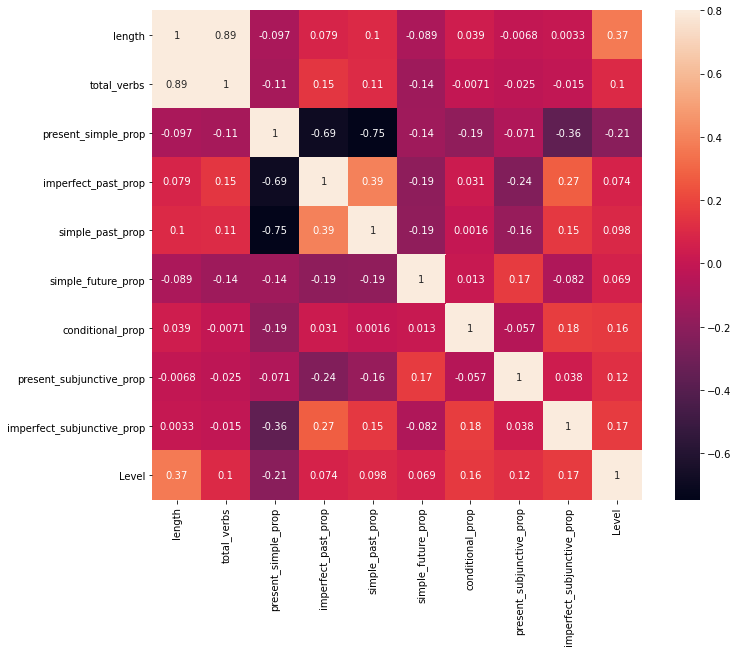

In [98]:
#Checking correlations against tense frequencies
df_freq = df.iloc[:, 11:22]
df_freq['Level'] = df['Level']

corrmat = df_freq.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, annot=True, vmax=.8, square=True, );

In [99]:
#Pivot Tables for verb tenses
#Imperfect Subjunctive total 

df[['imperfect_subjunctive_total', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,imperfect_subjunctive_total
5,6,0.975610
4,5,0.835052
3,4,0.868613
2,3,0.757812
1,2,0.220000
0,1,0.045455


In [100]:
#Imperfect Subjunctive Freq
df[['imperfect_subjunctive_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,imperfect_subjunctive_prop
5,6,0.023095
4,5,0.021371
3,4,0.020807
2,3,0.018046
1,2,0.006910
0,1,0.001109


In [101]:
#Present Simple Frequency
df[['present_simple_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,present_simple_prop
5,6,0.507368
4,5,0.501282
3,4,0.455547
2,3,0.530197
1,2,0.637994
0,1,0.830250


In [102]:
#Condtional
df[['conditional_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,conditional_prop
5,6,0.031392
4,5,0.022151
3,4,0.021814
2,3,0.023260
1,2,0.004834
0,1,0.011814


In [103]:
#Simple Future
df[['simple_future_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,simple_future_prop
5,6,0.042905
4,5,0.036646
3,4,0.048838
2,3,0.052281
1,2,0.019023
0,1,0.008515


In [104]:
#Simple Past
df[['simple_past_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,simple_past_prop
5,6,0.186586
4,5,0.176623
3,4,0.183236
2,3,0.169686
1,2,0.157134
0,1,0.048818


In [105]:
#present subjunctive
df[['present_subjunctive_prop', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,present_subjunctive_prop
5,6,0.058520
4,5,0.067565
3,4,0.073762
2,3,0.051357
1,2,0.039097
0,1,0.042659


In [106]:
#Making boolean columns for whether or not a tense appears in the text:

def IsTensePresent(freq):
    if freq > 0:
        q=1
    else:
        q=0
    return q

df['is_imperfect_subjunctive'] = df['imperfect_subjunctive_total'].apply(lambda x: IsTensePresent(x))
df['is_present_subjunctive'] = df['present_subjunctive_total'].apply(lambda x: IsTensePresent(x))
df['is_present_simple'] = df['present_simple_total'].apply(lambda x: IsTensePresent(x))
df['is_future_simple'] = df['simple_future_total'].apply(lambda x: IsTensePresent(x))
df['is_past_simple'] = df['simple_past_total'].apply(lambda x: IsTensePresent(x))
df['is_imperfect_past'] = df['imperfect_past_total'].apply(lambda x: IsTensePresent(x))
df['is_condtional'] = df['conditional_total'].apply(lambda x: IsTensePresent(x))
df['is_gerund'] = df['gerund_total'].apply(lambda x: IsTensePresent(x))
df['is_imperative'] = df['imperative_total'].apply(lambda x: IsTensePresent(x))

df['is_imperfect_subjunctive'].value_counts()

0    358
1    208
Name: is_imperfect_subjunctive, dtype: int64

In [107]:
df[['is_imperfect_subjunctive', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_imperfect_subjunctive
5,6,0.536585
4,5,0.432990
3,4,0.423358
2,3,0.359375
1,2,0.170000
0,1,0.045455


In [108]:
df[['is_condtional', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_condtional
5,6,0.512195
4,5,0.453608
3,4,0.423358
2,3,0.390625
1,2,0.130000
0,1,0.227273


In [109]:
df[['is_past_simple', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_past_simple
5,6,0.878049
4,5,0.855670
3,4,0.781022
2,3,0.773438
1,2,0.760000
0,1,0.500000


In [110]:
df[['is_gerund', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_gerund
5,6,0.768293
4,5,0.731959
3,4,0.708029
2,3,0.593750
1,2,0.390000
0,1,0.363636


In [111]:
df[['is_present_subjunctive', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,is_present_subjunctive
5,6,0.804878
4,5,0.762887
3,4,0.781022
2,3,0.664062
1,2,0.570000
0,1,0.454545


### Initial analysis of tense correlations
The results were to be expected with some surprises. I thought that there would be a steady introduction of different verb tenses as you progress through the levels, and whilst this appears to be true it seems even starting from A2 any verb tense might be present, albeit more complex tenses have a much lower lieklihood. A1 will likely be easy to distinguish as it is largely present tense with very few inclusions of other tenses. A2 will rarely contain conditional tenses or imperfect subjunctive tenses. From B1 the presence of verb tenses isn't particularly useful as all could be present.

I think the most useful way of expressing these data points is by proportion of total verbs for the more common tenses (present simple, past simple etc) and in boolean, present or not, form for the more complex tenses (imperfect subjunctive and conditional). As the more complex tenses are less common, it's very possible they'll only appear once or twice, their proportion will be more determined on the length of the text rather than difficulty.  

## Frequency of most common Spanish words
Here I will create a measure of what percentage of each text's words are one of the 1000 most common Spanish words or 100 most common verbs and their conjugations. This will theroretically shed light on the level of complexity of the text as the more difficult texts would use more unusual vocabulary.

I made a few edits to the 1000 most common Spanish words list, removing words like articles and pronouns that will show up at any level in order to make the result more meaningful. The 100 most common verb list includes the present, past, imperfect past, and future tense conjugations of each verb.

In [39]:
#Having scraped the list from 1000mostcommonwords, import to a dictionary here.
#I edited the list slightly, removing pronouns and connecting words that would appear at every level (30 or so words removed)
most_common_spanish = []
most_common_verbs = []

with open('./most_common_spanish2.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        word = line[:-1]

        # add item to the list
        most_common_spanish.append(word)
        
with open('./most_common_verbs.txt', 'r') as filehandle:
    for line in filehandle:
        verb = line[:-1]

        most_common_verbs.append(verb)
        
most_common_words = most_common_spanish + most_common_verbs
        
#Remove 'Spanish' which was an included header
most_common_words.remove('Spanish')

In [113]:
#determine percentage of common words
def CommonWords(text, most_common_words, length):
    common_words = [x for x in text if x in most_common_words]
    num_common_words = len(common_words)
    print(num_common_words, length)
    percentage = num_common_words/length
    return percentage

df['most_common_per'] = df.apply(lambda row: CommonWords(row['words_list'], most_common_words, row['length']), axis=1)

43 181
34 135
93 389
90 347
73 249
129 363
90 271
30 85
49 243
65 180
141 402
146 409
79 226
129 439
299 865
173 576
177 581
59 193
210 590
71 214
90 291
33 186
78 275
70 185
42 131
48 243
117 293
27 144
43 183
15 58
110 296
32 132
42 252
34 149
22 88
18 82
136 484
89 322
47 143
55 157
107 325
39 157
279 1005
113 551
108 356
39 212
45 163
39 143
63 297
64 331
76 306
70 386
34 244
100 324
54 208
40 132
64 177
83 276
148 565
15 60
173 513
60 172
117 487
178 571
107 397
136 477
74 320
98 463
40 141
65 271
64 216
38 185
158 499
41 320
203 705
169 585
80 346
119 390
46 191
215 629
69 230
85 224
67 235
63 209
100 326
62 246
78 279
7 90
78 210
163 598
64 232
136 406
192 679
195 642
159 507
118 342
167 534
135 438
136 414
202 642
111 413
30 136
252 792
102 409
151 484
140 454
230 594
121 551
78 299
228 674
219 677
23 113
168 567
56 171
54 225
98 325
50 191
126 447
46 136
34 137
42 147
23 90
235 780
32 146
31 141
30 164
143 524
74 293
142 382
207 658
80 283
116 463
188 586
250 819
26 107
34 99


In [114]:
#Taking a look at the correlation and pivot table
df['Level'].corr(df['most_common_per'])

-0.2951264753057374

In [115]:
df[['most_common_per', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,most_common_per
5,6,0.222037
4,5,0.249973
3,4,0.282177
2,3,0.276889
1,2,0.278637
0,1,0.309845


### Percentage of most frequent words initial analysis
There is a negative correlation there, with A1 having the highest mean percentage and C2 having the lowest. However, as with the verb tenses, the numbers get a bit jumbled in the middle.

## Average Sentence Length
Determining the average sentence length for each Text.

In [41]:
def AverageSentenceLength(words_list, z):
    terminals = set(['.', '?', '!']) # sets are efficient for "membership" tests
    terminal_count = 0
    
    #split at whitespace

    for item in words_list:
        last_char = item[-2:]
        #print(last_char)
        #print(last_char[-1:])
        #print(last_char[:1])
        if last_char[-1:] in terminals or last_char[:1] in terminals: # here is our membership test
            terminal_count += 1
    
    if terminal_count == 0:
        terminal_count = 1
        print('Zero full stops', z)

    avg = len(words_list)  / float(terminal_count)
    print(avg, len(words_list))
    return avg

In [119]:
#removing stray lone full stops from words_list as they will skew data
def RemoveFullStops(words_list):
    new_words_list = [x for x in words_list if x != '.']
    return new_words_list


df['new_words_list'] = df.apply(lambda row: RemoveFullStops(row['words_list']), axis=1)


In [120]:
df['av_sent_length'] = df.apply(lambda row: AverageSentenceLength(row['new_words_list'], row.name), axis=1)

7.24 181
6.428571428571429 135
6.015873015873016 379
5.073529411764706 345
4.333333333333333 247
6.830188679245283 362
6.4523809523809526 271
5.666666666666667 85
3.24 243
11.25 180
9.804878048780488 402
8.019607843137255 409
8.37037037037037 226
10.658536585365853 437
12.01388888888889 865
12.0 576
10.962264150943396 581
6.03125 193
11.346153846153847 590
14.266666666666667 214
6.928571428571429 291
4.769230769230769 186
10.576923076923077 275
9.736842105263158 185
7.705882352941177 131
11.571428571428571 243
10.464285714285714 293
4.8 144
5.71875 183
4.833333333333333 58
14.095238095238095 296
4.0 132
3.212121212121212 212
6.208333333333333 149
11.0 88
13.666666666666666 82
11.804878048780488 484
9.441176470588236 321
11.0 143
6.28 157
7.065217391304348 325
6.24 156
6.635135135135135 982
4.266129032258065 529
6.846153846153846 356
4.163265306122449 204
6.52 163
5.5 143
4.0 288
4.984615384615385 324
4.615384615384615 300
3.816326530612245 374
3.5606060606060606 235
17.05263157894737 3

In [121]:
print(df[df.av_sent_length > 30].av_sent_length)

302     32.642857
320     40.000000
360     34.555556
369     30.166667
371     81.000000
376     33.250000
379     30.772727
381     30.296296
387     39.117647
388     32.400000
396     31.750000
401     38.062500
405     31.400000
412     30.615385
414     31.250000
418     58.000000
421     34.200000
423     33.250000
425     47.818182
430     36.904762
431     31.580645
433     44.083333
436     32.769231
439     35.571429
441     35.833333
442     33.733333
450     30.714286
457     32.571429
470     51.166667
490    378.000000
528     68.250000
576     34.714286
Name: av_sent_length, dtype: float64


In [122]:
#Taking a look at the biggest values individually shows that the lengths above 60 are due to formatting erros
#for example because they are song lyrics or there are no spaces at the full stops
print(df.loc[431].Level, df.loc[490].words_list)

6 ['¿Desde', 'cuándo', 'esta', "'g'", 'está', 'mal', 'vista?.', 'Es', 'una', 'hipótesis', 'pero', 'todo', 'apunta', 'a', 'que', 'se', 'va', 'a', 'cumplir:', 'si', 'tu', 'cena', 'de', 'Navidad', 'evoluciona', 'favorablemente', 'y', 'termina', 'con', 'el', 'episodio', 'clásico', 'de', 'exaltación', 'de', 'la', 'amistad', 'es', 'posible', 'que', 'acabes', 'deseando', 'chispeantemente', 'una', 'feliz', 'Nochegüena', 'a', 'tus', 'cuñados', 'o', 'atrayendo', 'por', 'el', 'cuello', 'hacia', 'ti', 'al', 'plúmbeo', 'responsable', 'administrativo', 'de', 'tu', 'oficina', 'para', 'declararle', 'en', 'público:', 'este', 'tío', 'es', 'güeno', 'güeno', 'güeno.', 'Superada', 'la', 'resaca', 'y', 'si', 'aún', 'te', 'queda', 'cuerpo', 'y', 'vergüenza', 'dedícanos', 'un', 'rato', 'para', 'que', 'te', 'podamos', 'explicar', 'por', 'qué', 'en', 'tu', 'festiva', 'deriva', 'navideña', 'la', 'expresividad', 'te', 'ha', 'llevado', 'a', 'hacer', 'güeno', 'a', 'lo', 'que', 'igual', 'no', 'era', 'ni', 'siquiera'

In [123]:
#Removing the misformatted texts
df = df[df.av_sent_length < 50]

In [124]:
df['Level'].corr(df['av_sent_length'])

0.7053560131902339

In [125]:
df[['av_sent_length', 'Level']].groupby(['Level'], as_index=False).mean().sort_values(by='Level', ascending=False)

,Level,av_sent_length
5,6,26.559976
4,5,19.388384
3,4,15.867372
2,3,11.651772
1,2,9.301035
0,1,9.097510


In [126]:
df.Level.describe()

count    561.000000
mean       3.764706
std        1.403402
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: Level, dtype: float64

## Percentage of unique words in the text
Extracts the total number of unique words and divides by the length.

In [127]:
def UniqueWords(new_words_list):
    #Remove all punctuation as this will make the string look different
    stripped_list = [x.strip('?!.)(;:-') for x in new_words_list]
    #Put every character in lower case
    stripped_list = [x.lower() for x in stripped_list]
    text_set = set(stripped_list)
    unique_word_prop = len(text_set)/len(stripped_list)
    print(unique_word_prop, len(stripped_list))
    return unique_word_prop
    
    

In [128]:
df['unique_word_prop'] = df.apply(lambda row: UniqueWords(row['new_words_list']), axis=1)

0.6408839779005525 181
0.5777777777777777 135
0.43799472295514513 379
0.4956521739130435 345
0.4291497975708502 247
0.47513812154696133 362
0.5313653136531366 271
0.6823529411764706 85
0.5596707818930041 243
0.45 180
0.554726368159204 402
0.4058679706601467 409
0.5088495575221239 226
0.43478260869565216 437
0.27976878612716766 865
0.4097222222222222 576
0.32013769363166955 581
0.5699481865284974 193
0.4559322033898305 590
0.5747663551401869 214
0.5257731958762887 291
0.5752688172043011 186
0.49454545454545457 275
0.654054054054054 185
0.6335877862595419 131
0.6337448559670782 243
0.4334470989761092 293
0.6041666666666666 144
0.5737704918032787 183
0.5862068965517241 58
0.47297297297297297 296
0.49242424242424243 132
0.5754716981132075 212
0.5838926174496645 149
0.5454545454545454 88
0.5 82
0.47107438016528924 484
0.5514018691588785 321
0.5804195804195804 143
0.4012738853503185 157
0.6092307692307692 325
0.358974358974359 156
0.4175152749490835 982
0.43100189035916825 529
0.575842696629

In [129]:
#Taking a look at the mean values
pd.pivot_table(df, index ='Level', values=['unique_word_prop', 'length'])

,length,unique_word_prop
Level,,
1,189.909091,0.599853
2,287.459184,0.518816
3,314.000000,0.554777
4,368.029197,0.558674
5,425.927835,0.545421
6,520.375000,0.520725


This produced the opposite of what was expected and does not seem useful at all. The lower levels have a higher mean proportion of unique words in their texts. In hindsight, length of the text is likely the driving factor for this value rather than level. Words that occur every sentence in all levels such as pronouns or articles will gradually decrease the calculated number as length increases even though their proportion stays the same. Given length increases with level, the proportion of unique words will in turn decrease. This could be corrected by extracting those super common words before doing the calculation but based on the initial numbers it still wouldn't be useful. This feature won't be included in the model.

## Moving on to more in-depth analysis
Now that the feature's have been enigeered I will move on to do some further cleaning, feature selection and ultimately model building. This will be in the analysis_and_model notebook.

In [130]:
df.to_csv('cleaned_texts_with_codes2.csv', index=False, header=True)